# Power to detect a GWAS association as a function of selection and sampling

Maggie Steiner 1/9/23

## Notation

|  symbol | meaning   |
|---|---|
|$\ell$ |index of site   |
| $L$  | total number of sites  |
| $Z_\ell$  | allele frequency at site $\ell$  |
|$\alpha_*$ | significance threshold |
|$v_*$ | equal to $2\text{erf}^{-1}(1-\alpha_*)^2$
|$V_P$|phenotypic variance|
|$\beta$|effect size|
|$s$|selection coefficient|
|$n$|sample size|
|$\mu$|mutation rate|
|$\tilde{\beta}$| selection gradient|
|$\ell_c$|characteristic length|
|$d$| dimension|
|$\mathcal{N}$|population density|
|$\kappa$|cumulant|

## Power model

Applying the threshold model for power as described in Carlson et al. 2022, we claim that an association will be detected at site $\ell$ if the allele frequency $Z_\ell$ satisfies: $$Z_\ell>\frac{1}{2}-\frac{1}{2}\sqrt{\frac{1-2v_*(V_P/n)}{\beta_\ell^2}}$$

First, we claim that $s=\tilde{\beta}\cdot\beta$, i.e. selection ($s$) is proportional to effect size ($\beta$) with the constant of proportionality being the selection graident ($\tilde{\beta}$). (Note: Sanjak et al. 2018 estimates the selection gradient for human traits, with most values in the range $[-0.1,0.1]$.)

Next, consider the phenotypic variance $V_P$. We assume that $V_P$ can be decomposed into two independent parts, genetic variance ($V_G$) and environmental variance ($V_E$). We will assume that $V_G\perp V_E$ and that $V_E$ does not vary according to geography. Accordingly, $$V_P=V_G+V_E$$

## Genetic Variance

Now, consider $V_G$. Assuming (1) additivity, (2) $(\forall\ell)(\beta_\ell=\beta)$, and (3) $Z_1,\ldots,Z_L$ are IID according to the SFS, and using the fact that $\text{Var}(Z_\ell)=(2\mu\kappa_2)/(s^2\ell_c^d\mathcal{N})$, we have:
$$V_G=\text{Var}\left[\left(\sum_{\ell=1}^L\beta_\ell Z_\ell\right)\right]\\
=\beta^2\left(\sum_{\ell=1}^L\text{Var}(Z_\ell)\right)
=\beta^2L\cdot\frac{2\mu}{s^2\ell_c^d\mathcal{N}}\cdot\kappa_2$$

Substituting in the above expression relating $\beta$ to $s$:
$$V_G=\frac{2L\mu\kappa_2}{\tilde{\beta}^2\ell_c^d\mathcal{N}}$$

This implies that when the trait is highly polygenic (large $L$) or mutational input is large (large $\mu$), genetic variance is large. Conversely, when the selection gradient is large (large $\tilde{\beta}$) or the population is very dense (large $\mathcal{N}$, genetic variance is small.

This also implies that $V_G\propto\kappa_2$. The value of $\kappa_2$ decreases for larger $\sigma$ (broader sampling). Thus, for broader sampling, we expect less genetic variance.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("numerics_snakemake/spatial_integrals_dim2.csv")
data[1:5]

,sigma,u2_GQ,u3_GQ
1,0.010975,0.482353,0.121986
2,0.012045,0.474950,0.118325
3,0.013219,0.467547,0.114721
4,0.014508,0.460144,0.111181


In [17]:
def calc_V_G(kappa_list,s,sel_grad,L=1000,mu=1e-8,d=2,D=1,N=10000):
    V_list = [(2*L*mu*k)/(sel_grad**2*np.sqrt(D/s)**d*N) for k in kappa_list]
    return(V_list)

sigma_list = data['sigma'].tolist()

### $V_G$ decreases for larger selection gradient and for broader sampling

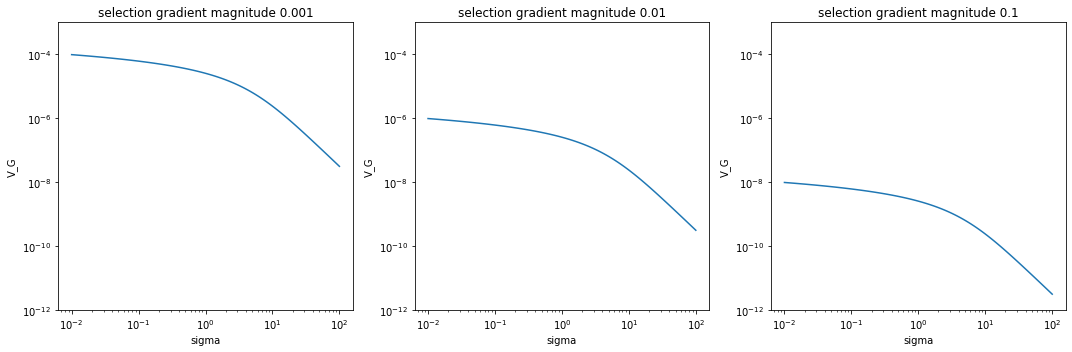

In [27]:
sel_grad = [0.001, 0.01, 0.1]
fig, axs = plt.subplots(1,3,figsize=(15,5))
for i in range(3):
    axs[i].plot(sigma_list,calc_V_G(data['u2_GQ'].tolist(),s=0.1,sel_grad=sel_grad[i]))
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    axs[i].set_title("selection gradient magnitude "+str(sel_grad[i]))
    axs[i].set_ylim(1e-12,1e-3)
    axs[i].set_xlabel("sigma")
    axs[i].set_ylabel("V_G")
    
plt.tight_layout()
plt.show()

### $V_G$ increases for higher polygenicity and large mutation rage

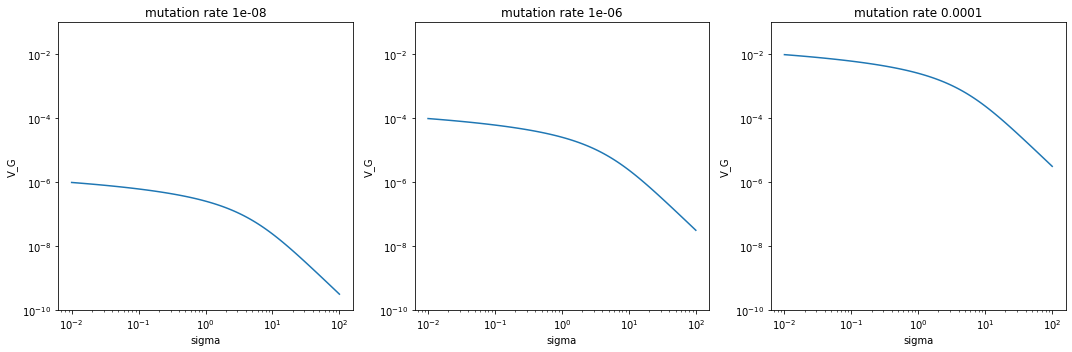

In [22]:
mu_list = [1e-8, 1e-6, 1e-4]
fig, axs = plt.subplots(1,3,figsize=(15,5))
for i in range(3):
    axs[i].plot(sigma_list,calc_V_G(data['u2_GQ'].tolist(),s=0.1,sel_grad=0.01,mu=mu_list[i]))
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    axs[i].set_title("mutation rate "+str(mu_list[i]))
    axs[i].set_ylim(1e-10,1e-1)
    axs[i].set_xlabel("sigma")
    axs[i].set_ylabel("V_G")
    
plt.tight_layout()
plt.show()

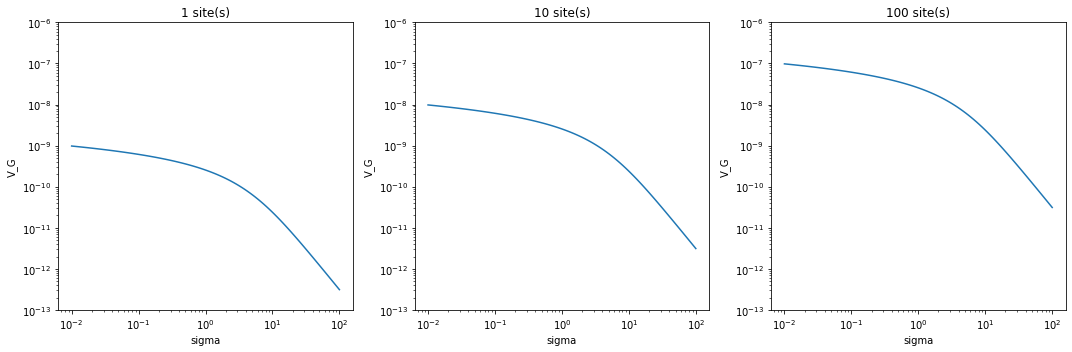

In [25]:
L_list = [1,10,100]
fig, axs = plt.subplots(1,3,figsize=(15,5))
for i in range(3):
    axs[i].plot(sigma_list,calc_V_G(data['u2_GQ'].tolist(),s=0.1,sel_grad=0.01,L=L_list[i]))
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    axs[i].set_title(str(L_list[i])+" site(s)")
    axs[i].set_ylim(1e-13,1e-6)
    axs[i].set_xlabel("sigma")
    axs[i].set_ylabel("V_G")
    
plt.tight_layout()
plt.show()

## Calculating power

Now, we have $$V_P=V_G+V_E$$ where $V_E$ is constant and we can calculate $V_G$ as above. Then, by setting values for $V_E$, $v_*$, and $n$, we can calculate the threshold statistic $Z^*$. Then, power is calculated as follows:
$$\mathbb{P}\{Z_ell>Z^*|s,\alpha,\sigma,\ldots\}=1-\mathbb{P}\{Z_\ell<Z^*|\ldots\}\\
=1-\int_0^{Z^*}g(z)dz$$
for $g(z)$ the density of a Gamma distribution with shape and rate as calculated previously (this is the sample SFS). 

In [82]:
from scipy.special import erfinv
from scipy.stats import gamma
import sys
import math
sys.path.insert(1,'numerics_snakemake')
from plot_sfs import *

data_pr = pd.read_csv("numerics_snakemake/cleaned_data_dim2_errorFalse.csv")
data_pr = data_pr.loc[data_pr['poly_type']=='1_1']

def power(zs, sigma, s, sigma_vals, res_vals, pole_vals, Nval=10000):
    beta = rate_p(sigma,s,sigma_vals,pole_vals,N=Nval)
    alpha = shape_p(sigma,s,sigma_vals,res_vals,N=Nval)
    return(1-gamma.cdf(zs,a=alpha,scale=1/beta))

def get_zs(s,sel_grad,Vp,n=10000,a=1e-8):
    vs = 2*erfinv(1-a)**2
    return(0.5 - (0.5)*math.sqrt((1-2*vs*(Vp/n))/(s*sel_grad)**2))

def power_all(sigma,s,sel_grad,sigma_vals=data['sigma'].tolist(),kappa_list=data['u2_GQ'].tolist(),
              res_vals=data_pr['residues'],pole_vals=data_pr['poles'],
              Ve=0.1,Nval=10000,n=10000,a=1e-8,L=10000,mu=1e-8,d=2,D=1):
    Vp=calc_V_G(kappa_list,s,sel_grad,N=Nval)[sigma_vals.index(sigma)]+Ve
    zs=get_zs(s,sel_grad=sel_grad,Vp=Vp)
    power_val = power(zs,sigma,s,sigma_vals,res_vals,pole_vals,Nval)
    return(power_val)
                                                                                                                              
    
                                                        

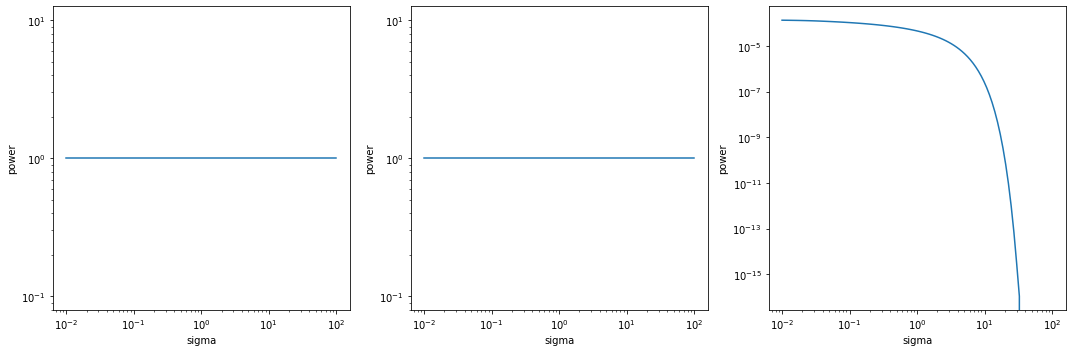

In [83]:
s_list = [0.001,0.01,0.1]
fig, axs = plt.subplots(1,3,figsize=(15,5))
for i in range(3):
    axs[i].plot(sigma_list,[power_all(sigma=sg,s=s_list[i],sel_grad=10,Nval=10000,n=1000000) for sg in sigma_list])
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    axs[i].set_xlabel("sigma")
    axs[i].set_ylabel("power")
    
plt.tight_layout()
plt.show()